# Daytona SDK Examples

Load the Daytona SDK and create a sandbox

In [1]:
from daytona_sdk import Daytona, ChartType, DaytonaConfig, WorkspaceTargetRegion, CreateWorkspaceParams, WorkspaceResources
from pprint import pp
import matplotlib.pyplot as plt
import io
import base64

config = DaytonaConfig(
    api_key="dtn_0d522da04d7e07c4da8693edce78b43d58b20822bf6a98eb478615065aa445ac",
    server_url="https://stage.daytona.work/api",
    target=WorkspaceTargetRegion.ASIA
)
daytona = Daytona(config)

In [2]:
sandbox = daytona.create(CreateWorkspaceParams(
    language="python",
    resources=WorkspaceResources(
      cpu=2,
      memory=2,
      disk=1
    )
))

print(sandbox.id)

sandbox-c0ae1bdc


## Code and Command Execution

### Code Execution

In [ ]:
response = sandbox.process.code_run('print("Hello World!")')
if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)

### Command Execution

In [ ]:
response = sandbox.process.exec('echo "Hello World from exec!"', cwd="/home/daytona", timeout=10)
if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)

### Exec Sessions

Sessions can be used to execute multiple commands in a single shell that preserves context between commands.

In [1]:
exec_session_id = "exec-session-1"
sandbox.process.create_session(exec_session_id)
session = sandbox.process.get_session(exec_session_id)
pp(session)
print()

# Execute the first command in the session
execCommand1 = sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(command="export FOO=BAR"))
if execCommand1.exit_code != 0:
    print(f"Error: {execCommand1.exit_code} {execCommand1.output}")

# Get the command details
session_command = sandbox.process.get_session_command(exec_session_id, execCommand1.cmd_id)
pp(session_command)
print()

# Execute a second command in the session and see that the environment variable is set
execCommand2 = sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(command="echo $FOO"))
if execCommand2.exit_code != 0:
    print(f"Error: {execCommand2.exit_code} {execCommand2.output}")
else:
    print(f"Output: {execCommand2.output}\n")

logs = sandbox.process.get_session_command_logs(exec_session_id, execCommand2.cmd_id)
print(f"Logs: {logs}")

NameError: name 'sandbox' is not defined

### Charts

Daytona automatically detects any plots creations while running remote code and saves them in `response.artifacts.charts`. This feature is available only for **Matplotlib** plots.

In [2]:
from daytona_sdk import Daytona, ChartType, DaytonaConfig, WorkspaceTargetRegion, CreateWorkspaceParams, WorkspaceResources
from pprint import pp
import matplotlib.pyplot as plt
import io
import base64

config = DaytonaConfig(
    api_key="dtn_ba5b69d5804faf5900b2473566e76561da28b1187973bf1b07a2d25147f36685",
    server_url="https://app.daytona.io/api",
    target=WorkspaceTargetRegion.EU
)
daytona = Daytona(config)

sandbox = daytona.create(CreateWorkspaceParams(
    language="python",
    resources=WorkspaceResources(
      cpu=2,
      memory=2,
      disk=1
    ),
    auto_stop_interval=0
))

print(f"sandbox id {sandbox.id}")

/tmp/ipykernel_12251/2120042052.py:10: DeprecationWarning: `WorkspaceTargetRegion` is deprecated. Please use `SandboxTargetRegion` instead. This will be removed in a future version.
  target=WorkspaceTargetRegion.EU
/tmp/ipykernel_12251/2120042052.py:16: DeprecationWarning: `WorkspaceResources` is deprecated. Please use `SandboxResources` instead. This will be removed in a future version.
  resources=WorkspaceResources(
/tmp/ipykernel_12251/2120042052.py:14: DeprecationWarning: `CreateWorkspaceParams` is deprecated. Please use `CreateSandboxParams` instead. This will be removed in a future version.
  sandbox = daytona.create(CreateWorkspaceParams(


sandbox id sandbox-76c048ca


colorbar: Axes(0.78375,0.11;0.0240625x0.77)
children:  [<matplotlib.collections.LineCollection object at 0x76ae23218ad0>, <matplotlib.collections.QuadMesh object at 0x76ae23218d70>, <matplotlib.spines.Spine object at 0x76ae23242210>, <matplotlib.spines.Spine object at 0x76ae23242350>, <matplotlib.spines.Spine object at 0x76ae23242490>, <matplotlib.spines.Spine object at 0x76ae232425d0>, <matplotlib.colorbar._ColorbarSpine object at 0x76ae23218980>, <matplotlib.axis.XAxis object at 0x76ae23242850>, <matplotlib.axis.YAxis object at 0x76ae23242c10>, Text(0.5, 1.0, ''), Text(0.0, 1.0, ''), Text(1.0, 1.0, ''), <matplotlib.patches.Rectangle object at 0x76ae20f00410>]



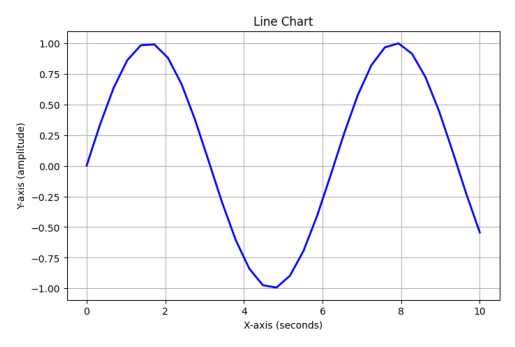

type: line
title: Line Chart
x_label: X-axis (seconds)
y_label: Y-axis (amplitude)
x_unit: None
y_unit: None
x_ticks: [-2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
x_tick_labels: ['−2', '0', '2', '4', '6', '8', '10', '12']
x_scale: linear
y_ticks: [-1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25]
y_tick_labels: ['−1.25', '−1.00', '−0.75', '−0.50', '−0.25', '0.00', '0.25', '0.50', '0.75', '1.00', '1.25']
y_scale: linear
elements:

* label: _child0
* points: [[0.0, 0.0], [0.3448275862068966, 0.3380344178335103], [0.6896551724137931, 0.6362711974814501], [1.0344827586206897, 0.8595981763240232], [1.3793103448275863, 0.9817225101058533], [1.7241379310344829, 0.9882661953069056], [2.0689655172413794, 0.878458827488186], [2.413793103448276, 0.6652283029348345], [2.7586206896551726, 0.37367878506512486], [3.1034482758620694, 0.03813512843002494], [3.4482758620689657, -0.301898272335703], [3.793103448275862, -0.6063884337819878], [4.137931034482759, -0.8394869669963327], [4.4827

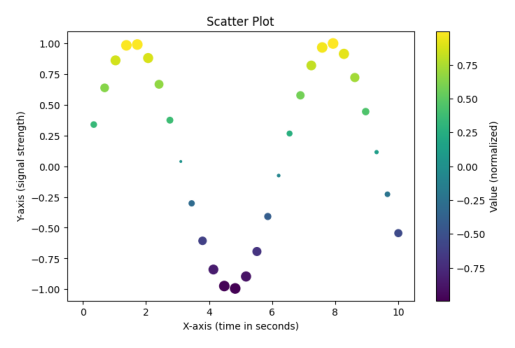

type: scatter
title: Scatter Plot
x_label: X-axis (time in seconds)
y_label: Y-axis (signal strength)
x_unit: None
y_unit: None
x_ticks: [-2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
x_tick_labels: ['−2', '0', '2', '4', '6', '8', '10', '12']
x_scale: linear
y_ticks: [-1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25]
y_tick_labels: ['−1.25', '−1.00', '−0.75', '−0.50', '−0.25', '0.00', '0.25', '0.50', '0.75', '1.00', '1.25']
y_scale: linear
elements:

* label: Scatter 1
* points: [[0.0, 0.0], [0.3448275862068966, 0.3380344178335103], [0.6896551724137931, 0.6362711974814501], [1.0344827586206897, 0.8595981763240232], [1.3793103448275863, 0.9817225101058533], [1.7241379310344829, 0.9882661953069056], [2.0689655172413794, 0.878458827488186], [2.413793103448276, 0.6652283029348345], [2.7586206896551726, 0.37367878506512486], [3.1034482758620694, 0.03813512843002494], [3.4482758620689657, -0.301898272335703], [3.793103448275862, -0.6063884337819878], [4.137931034482759, -0.83948

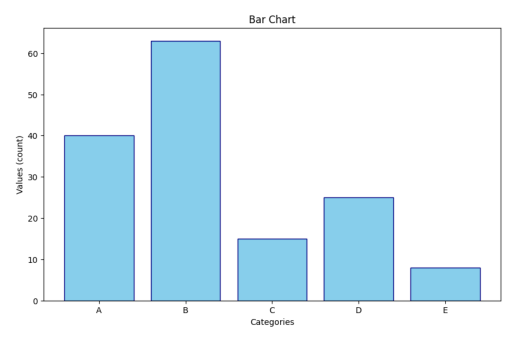

type: bar
title: Bar Chart
x_label: Categories
y_label: Values (count)
x_unit: None
y_unit: None
elements:

* label: A
* group: default
* value: 40.0

* label: B
* group: default
* value: 63.0

* label: C
* group: default
* value: 15.0

* label: D
* group: default
* value: 25.0

* label: E
* group: default
* value: 8.0



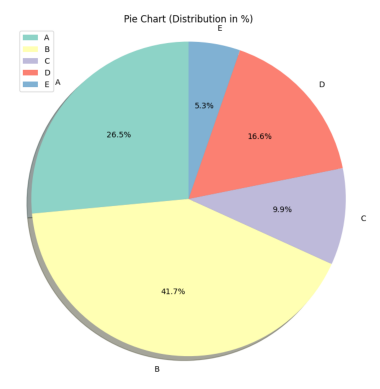

type: pie
title: Pie Chart (Distribution in %)
elements:

* label: A
* angle: 95.36424255371094
* radius: 1.0
* autopct: 26.5%

* label: B
* angle: 150.1986846923828
* radius: 1.0
* autopct: 41.7%

* label: C
* angle: 35.761566162109375
* radius: 1.0
* autopct: 9.9%

* label: D
* angle: 59.602630615234375
* radius: 1.0
* autopct: 16.6%

* label: E
* angle: 19.0728759765625
* radius: 1.0
* autopct: 5.3%



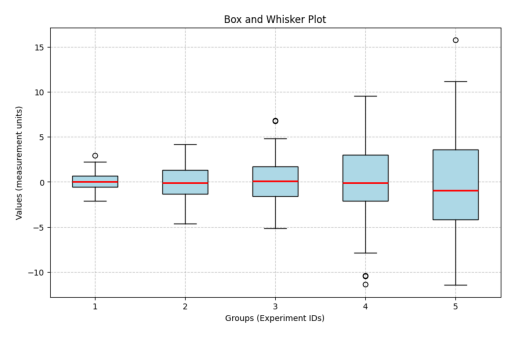

type: box_and_whisker
title: Box and Whisker Plot
x_label: Groups (Experiment IDs)
y_label: Values (measurement units)
x_unit: None
y_unit: None
elements:

* label: 1
* min: -2.0775648457890203
* first_quartile: -1.029474411862028
* median: 0.0186160220649642
* third_quartile: 1.1168952374955075
* max: 2.2151744529260506
* outliers: [2.9689026395511102]

* label: 2
* min: -2.0775648457890203
* first_quartile: -1.0902018831746223
* median: -0.10283892056022431
* third_quartile: 1.0561677661829132
* max: 2.2151744529260506
* outliers: [2.9689026395511102]

* label: 3
* min: 0.0186160220649642
* first_quartile: 0.05559153000852882
* median: 0.09256703795209344
* third_quartile: -0.6265042836354374
* max: -1.3455756052229682
* outliers: [2.9689026395511102]

* label: 4
* min: 1.3121528009418388
* first_quartile: 0.6180951280102769
* median: -0.07596254492128496
* third_quartile: -2.3461723292498524
* max: -4.616382113578419
* outliers: [2.9689026395511102]

* label: 5
* min: 4.196769823616

In [3]:


matplotlib_code = """
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 30)
y = np.sin(x)
categories = ['A', 'B', 'C', 'D', 'E']
values = [40, 63, 15, 25, 8]
box_data = [np.random.normal(0, std, 100) for std in range(1, 6)]

# 1. Line Chart
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b-', linewidth=2)
plt.title('Line Chart')
plt.xlabel('X-axis (seconds)')  # Added unit
plt.ylabel('Y-axis (amplitude)')  # Added unit
plt.grid(True)
plt.show()

# 2. Scatter Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, c=y, cmap='viridis', s=100*np.abs(y))
plt.colorbar(label='Value (normalized)')  # Added unit
plt.title('Scatter Plot')
plt.xlabel('X-axis (time in seconds)')  # Added unit
plt.ylabel('Y-axis (signal strength)')  # Added unit
plt.show()

# 3. Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue', edgecolor='navy')
plt.title('Bar Chart')
plt.xlabel('Categories')  # No change (categories don't have units)
plt.ylabel('Values (count)')  # Added unit
plt.show()

# 4. Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=categories,
        autopct='%1.1f%%',
        colors=plt.cm.Set3.colors, shadow=True, startangle=90)
plt.title('Pie Chart (Distribution in %)')  # Modified title
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.legend()
plt.show()

# 5. Box and Whisker Plot
plt.figure(figsize=(10, 6))
plt.boxplot(box_data, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red', linewidth=2))
plt.title('Box and Whisker Plot')
plt.xlabel('Groups (Experiment IDs)')  # Added unit
plt.ylabel('Values (measurement units)')  # Added unit
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
"""

import matplotlib.pyplot as plt
import numpy as np

response = sandbox.process.code_run(matplotlib_code)

print(response.artifacts.stdout)

if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    for chart in response.artifacts.charts:
        img_data = base64.b64decode(chart.png)
        img = plt.imread(io.BytesIO(img_data))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print(chart)

# daytona.remove(sandbox) 

colorbar: Axes(0.907537,0.660787;0.0119468x0.238935)
children:  [<matplotlib.collections.LineCollection object at 0x70602b8202f0>, <matplotlib.collections.QuadMesh object at 0x70602b820590>, <matplotlib.spines.Spine object at 0x70602b9d9310>, <matplotlib.spines.Spine object at 0x70602b9d9450>, <matplotlib.spines.Spine object at 0x70602b9d9590>, <matplotlib.spines.Spine object at 0x70602b9d96d0>, <matplotlib.colorbar._ColorbarSpine object at 0x70602b8201a0>, <matplotlib.axis.XAxis object at 0x70602b9d9810>, <matplotlib.axis.YAxis object at 0x70602b9d9bd0>, Text(0.5, 1.0, ''), Text(0.0, 1.0, ''), Text(1.0, 1.0, ''), <matplotlib.patches.Rectangle object at 0x70602b9db250>]



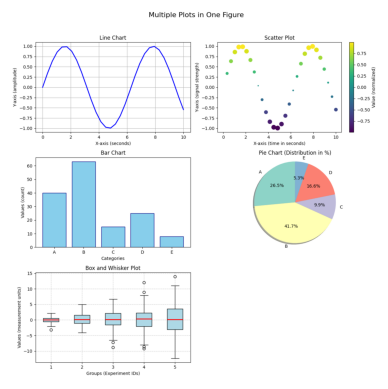

TypeError: 'NoneType' object is not iterable

In [3]:
matplotlib_code = """
import matplotlib.pyplot as plt
import numpy as np

# Data
x = np.linspace(0, 10, 30)
y = np.sin(x)
categories = ['A', 'B', 'C', 'D', 'E']
values = [40, 63, 15, 25, 8]
box_data = [np.random.normal(0, std, 100) for std in range(1, 6)]

# Create a figure with 5 subplots (arranged in a grid)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns
fig.suptitle("Multiple Plots in One Figure", fontsize=16)

# 1. Line Chart
ax1 = axes[0, 0]
ax1.plot(x, y, 'b-', linewidth=2)
ax1.set_title('Line Chart')
ax1.set_xlabel('X-axis (seconds)')
ax1.set_ylabel('Y-axis (amplitude)')
ax1.grid(True)

# 2. Scatter Plot
ax2 = axes[0, 1]
sc = ax2.scatter(x, y, c=y, cmap='viridis', s=100 * np.abs(y))
fig.colorbar(sc, ax=ax2, label='Value (normalized)')
ax2.set_title('Scatter Plot')
ax2.set_xlabel('X-axis (time in seconds)')
ax2.set_ylabel('Y-axis (signal strength)')

# 3. Bar Chart
ax3 = axes[1, 0]
ax3.bar(categories, values, color='skyblue', edgecolor='navy')
ax3.set_title('Bar Chart')
ax3.set_xlabel('Categories')
ax3.set_ylabel('Values (count)')

# 4. Pie Chart
ax4 = axes[1, 1]
ax4.pie(values, labels=categories, autopct='%1.1f%%',
        colors=plt.cm.Set3.colors, shadow=True, startangle=90)
ax4.set_title('Pie Chart (Distribution in %)')
ax4.axis('equal')  # Keep the pie chart circular

# 5. Box and Whisker Plot
ax5 = axes[2, 0]
ax5.boxplot(box_data, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red', linewidth=2))
ax5.set_title('Box and Whisker Plot')
ax5.set_xlabel('Groups (Experiment IDs)')
ax5.set_ylabel('Values (measurement units)')
ax5.grid(True, linestyle='--', alpha=0.7)

# Hide the empty subplot in the grid
axes[2, 1].axis('off')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Avoid overlapping with the main title
plt.show()
"""

import matplotlib.pyplot as plt
import numpy as np

response = sandbox.process.code_run(matplotlib_code)

print(response.artifacts.stdout)

if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    for chart in response.artifacts.charts:
        img_data = base64.b64decode(chart.png)
        img = plt.imread(io.BytesIO(img_data))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print(chart)

# daytona.remove(sandbox) 

## File System

- List Files
- Create Folder
- Upload File
- Download File
- Replace in Files
- Search Files
- Get File Info
- Move Files
- Delete File
- Set File Permissions

In [ ]:
# Get sandbox root directory
root_dir = sandbox.get_user_root_dir()

# List files in the sandbox
files = sandbox.fs.list_files(root_dir)
pp(files)

# Create a new directory in the sandbox
new_dir = os.path.join(root_dir, "new-dir")
sandbox.fs.create_folder(new_dir, "755")

file_path = os.path.join(new_dir, "data.txt")

# Add a new file to the sandbox
file_content = b"Hello, World!"
sandbox.fs.upload_file(file_path, file_content)

# Search for the file we just added
matches = sandbox.fs.find_files(root_dir, "World!")
pp(matches)

# Replace the contents of the file
sandbox.fs.replace_in_files([file_path], "Hello, World!", "Goodbye, World!")

# Read the file
downloaded_file = sandbox.fs.download_file(file_path)
print("File content:", downloaded_file.decode("utf-8"))

# Change the file permissions
sandbox.fs.set_file_permissions(file_path, mode="777")

# Get file info
file_info = sandbox.fs.get_file_info(file_path)
pp(file_info)  # Should show the new permissions

# Move the file to the new location
new_file_path = os.path.join(root_dir, "moved-data.txt")
sandbox.fs.move_files(file_path, new_file_path)

# Find the file in the new location
search_results = sandbox.fs.search_files(root_dir, "moved-data.txt")
pp(search_results)

# Delete the file
sandbox.fs.delete_file(new_file_path)

## Git

- Clone Repository
- Pull Repository
- List Branches
- Delete a Branch
- Create a Branch
- Checkout a Branch
- Git Log
- Git Status
- Git Add
- Git Commit

In [ ]:
root_dir = sandbox.get_user_root_dir()
project_dir = os.path.join(root_dir, "learn-typescript")

# Clone the repository
sandbox.git.clone("https://github.com/panaverse/learn-typescript", project_dir, "master")

sandbox.git.pull(project_dir)

branches = sandbox.git.branches(project_dir)
pp(branches)

## LSP

- Start Language Server
- Notify Language Server of Document Change
- Get Completions
- Document Symbols
- Workspace Symbols

In [ ]:
root_dir = sandbox.get_user_root_dir()
project_dir = os.path.join(root_dir, "learn-typescript")

# Search for the file we want to work on
matches = sandbox.fs.find_files(project_dir, "var obj1 = new Base();")
print("Matches:", matches)

# Start the language server
lsp = sandbox.create_lsp_server("typescript", project_dir)
lsp.start()

# Notify the language server of the document we want to work on
lsp.did_open(matches[0].file)

# Get symbols in the document
symbols = lsp.document_symbols(matches[0].file)
print("Symbols:", symbols)

# Fix the error in the document
sandbox.fs.replace_in_files([matches[0].file], "var obj1 = new Base();", "var obj1 = new E();")

# Notify the language server of the document change
lsp.did_close(matches[0].file)
lsp.did_open(matches[0].file)

# Get completions at a specific position
completions = lsp.completions(matches[0].file, {"line": 12, "character": 18})
print("Completions:", completions)

## Sandbox Management

- List Sandboxes
- Stop Sandbox
- Start Sandbox
- Remove Sandbox

In [ ]:
sandboxes = daytona.list()
print(f"Total sandboxes count: {len(sandboxes)}")

for s in sandboxes:
    print(s.id)
    pp(s.info())
    print()

In [38]:
daytona.stop(sandbox)

In [39]:
daytona.start(sandbox)

In [40]:
daytona.remove(sandbox)